# Remap Regular Lat/Lon Grid to HEALPix

This notebook demonstrates how to remap a regular latitude/longitude grid dataset to HEALPix grid using easygems.remap.

Adapted from the unstructured grid examples to work with regular grids like the MERG dataset.

**New Features**: Weight saving and loading for efficient reuse!

In [1]:
import numpy as np
import xarray as xr
import healpix as hp
import easygems.remap as egr
import easygems.healpix as egh
import matplotlib.pyplot as plt
import matplotlib as mpl
import colormaps as cmaps
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path

## Weight Management Functions

These functions allow you to save and reuse remapping weights, saving significant computation time for multiple datasets with the same grid.

In [2]:
def save_weights(weights, weights_file):
    """Save remapping weights to NetCDF file."""
    weights_path = Path(weights_file)
    weights_path.parent.mkdir(parents=True, exist_ok=True)
    
    print(f"Saving weights to {weights_path}")
    
    # Use compression for efficient storage
    encoding = {}
    for var in weights.data_vars:
        if weights[var].dtype.kind in ['i', 'u']:  # Integer variables
            encoding[var] = {'zlib': True, 'complevel': 4, 'dtype': 'int32'}
        elif weights[var].dtype.kind == 'f':  # Float variables
            encoding[var] = {'zlib': True, 'complevel': 4, 'dtype': 'float32'}
    
    weights.to_netcdf(weights_path, encoding=encoding)
    print(f"Weights saved successfully ({weights_path.stat().st_size / 1024**2:.1f} MB)")


def load_weights(weights_file):
    """Load remapping weights from NetCDF file."""
    weights_path = Path(weights_file)
    if not weights_path.exists():
        raise FileNotFoundError(f"Weights file not found: {weights_path}")
    
    print(f"Loading weights from {weights_path}")
    weights = xr.open_dataset(weights_path)
    
    # Print some info about the loaded weights
    if 'healpix_order' in weights.attrs:
        print(f"  HEALPix order: {weights.attrs['healpix_order']}")
    if 'source_shape' in weights.attrs:
        print(f"  Source grid: {weights.attrs['source_shape']}")
    if 'creation_date' in weights.attrs:
        print(f"  Created: {weights.attrs['creation_date']}")
    
    return weights

## Define the remapping functions

In [3]:
def gen_weights_latlon(lon, lat, order, weights_file=None, force_recompute=False):
    """
    Generate remapping weights from regular lat/lon grid to HEALPix grid.
    
    Parameters:
    -----------
    lon : array-like
        1D array of longitude values in degrees
    lat : array-like  
        1D array of latitude values in degrees
    order : int
        HEALPix order (zoom level)
    weights_file : str or Path, optional
        Path to save/load weights NetCDF file
    force_recompute : bool, default=False
        If True, recompute weights even if weights_file exists
        
    Returns:
    --------
    weights : Dataset
        Remapping weights for use with easygems.remap.apply_weights
    """
    
    # Check if we should load existing weights
    if weights_file is not None and not force_recompute:
        weights_path = Path(weights_file)
        if weights_path.exists():
            try:
                return load_weights(weights_path)
            except Exception as e:
                print(f"Error loading weights: {e}, recomputing...")
    
    nside = hp.order2nside(order)
    npix = hp.nside2npix(nside)
    
    # Get HEALPix pixel coordinates
    hp_lon, hp_lat = hp.pix2ang(
        nside=nside, ipix=np.arange(npix), lonlat=True, nest=True
    )
    
    # Create 2D meshgrid from 1D lat/lon arrays
    lon_2d, lat_2d = np.meshgrid(lon, lat)
    
    # Flatten to 1D for weight computation
    source_lon = lon_2d.flatten()
    source_lat = lat_2d.flatten()
    
    # For global grids, handle periodicity
    if np.max(lon) - np.min(lon) >= 359:  # Global grid
        print("Handling longitude periodicity for global grid")
        
        # Extend grid periodically in longitude
        lon_extended = np.hstack([source_lon - 360, source_lon, source_lon + 360])
        lat_extended = np.tile(source_lat, 3)
        
        # Compute weights using extended grid
        weights = egr.compute_weights_delaunay(
            points=(lon_extended, lat_extended), 
            xi=(hp_lon, hp_lat)
        )
        
        # Remap source indices back to original grid size
        original_size = len(source_lon)
        weights = weights.assign(src_idx=weights.src_idx % original_size)
        
    else:
        # Regional grid - no periodicity handling
        print("Regional grid detected, no periodicity handling")
        weights = egr.compute_weights_delaunay(
            points=(source_lon, source_lat), 
            xi=(hp_lon, hp_lat)
        )
    
    # Add metadata about the grid configuration
    weights.attrs.update({
        'healpix_order': order,
        'healpix_nside': nside,
        'healpix_npix': npix,
        'source_grid_type': 'regular_latlon',
        'source_shape': f"{len(lat)} x {len(lon)}",
        'source_lon_range': f"{np.min(lon):.3f} to {np.max(lon):.3f}",
        'source_lat_range': f"{np.min(lat):.3f} to {np.max(lat):.3f}",
        'source_resolution': f"~{np.diff(lon).mean():.4f}° x {np.diff(lat).mean():.4f}°",
        'creation_date': str(np.datetime64('now')),
        'description': 'Remapping weights from regular lat/lon grid to HEALPix'
    })
    
    # Save weights if requested
    if weights_file is not None:
        save_weights(weights, weights_file)
    
    return weights

In [16]:
def remap_latlon_to_healpix(ds, order, weights_file=None, force_recompute=False):
    """
    Remap a dataset from regular lat/lon grid to HEALPix grid.
    
    Parameters:
    -----------
    ds : xr.Dataset
        Input dataset with lat/lon coordinates
    order : int
        HEALPix order (zoom level)
    weights_file : str or Path, optional
        Path to save/load weights NetCDF file
    force_recompute : bool, default=False
        If True, recompute weights even if weights_file exists
        
    Returns:
    --------
    ds_remap : xr.Dataset
        Dataset remapped to HEALPix grid with 'cell' dimension
    """
    
    # Generate remapping weights
    print(f"Generating weights for HEALPix order {order}")
    weights = gen_weights_latlon(ds.lon.values, ds.lat.values, order, weights_file, force_recompute)
    
    # Get HEALPix parameters
    nside = hp.order2nside(order)
    npix = len(weights.tgt_idx)
    print(f"Remapping to {npix} HEALPix pixels (nside={nside})")
    
    # Custom remapping function that properly handles the data structure
    def remap_variable(data_array_xr, data_values, src_idx, weights_vals, valid):
        """Apply weights to a single variable with proper data handling."""
        # Ensure data is loaded and not a dask array for indexing
        if hasattr(data_values, 'compute'):
            data_values = data_values.compute()
        
        # Check if we need to transpose based on xarray dimension order
        original_shape = data_values.shape
        dims = data_array_xr.dims
        
        if len(original_shape) == 3:  # time, lat, lon or time, lon, lat
            # Handle both (time, lat, lon) and (time, lon, lat) cases
            if 'lat' in dims and 'lon' in dims:
                # Check dimension order and transpose if needed
                if list(dims) == ['time', 'lon', 'lat']:
                    # Transpose from (time, lon, lat) to (time, lat, lon)
                    data_values = data_values.transpose(0, 2, 1)
                    original_shape = data_values.shape
                
            data_flat = data_values.reshape(original_shape[0], -1)  # time, lat*lon
            result = np.zeros((original_shape[0], len(valid)))
            
            for t in range(original_shape[0]):
                result[t] = np.where(valid, (data_flat[t][src_idx] * weights_vals).sum(axis=-1), np.nan)
                
        elif len(original_shape) == 2:  # lat, lon
            # For 2D variables, check if they have spatial dimensions that match the grid
            expected_size = len(ds.lat) * len(ds.lon)
            actual_size = np.prod(original_shape)
            
            if actual_size != expected_size:
                print(f"Skipping variable with incompatible dimensions: {original_shape} (expected {len(ds.lat)}x{len(ds.lon)})")
                return None
                
            data_flat = data_values.flatten()  # lat*lon
            result = np.where(valid, (data_flat[src_idx] * weights_vals).sum(axis=-1), np.nan)
        else:
            raise ValueError(f"Unsupported data shape: {original_shape}")
            
        return result
    
    # Filter data variables to only include those with spatial dimensions
    def should_remap_variable(var_name, data_array):
        """Determine if a variable should be remapped based on its dimensions."""
        # Skip coordinate bounds variables
        if var_name.endswith('_bnds') or var_name.endswith('_bounds'):
            return False
            
        # Only remap variables that have both lat and lon dimensions
        # or have spatial dimensions matching the grid
        dims = data_array.dims
        
        if 'lat' in dims and 'lon' in dims:
            return True
        
        # For variables without explicit lat/lon dims, check if shape matches spatial grid
        if len(data_array.shape) >= 2:
            # Check if any two dimensions match lat/lon sizes
            lat_size, lon_size = len(ds.lat), len(ds.lon)
            shape = data_array.shape
            
            # For 3D: check if last two dims match lat,lon
            if len(shape) == 3 and (shape[-2:] == (lat_size, lon_size) or shape[-2:] == (lon_size, lat_size)):
                return True
            # For 2D: check if dims match lat,lon
            elif len(shape) == 2 and (shape == (lat_size, lon_size) or shape == (lon_size, lat_size)):
                return True
                
        return False
    
    # Create new dataset with remapped variables
    remapped_vars = {}
    
    for var_name in ds.data_vars:
        data_array = ds[var_name]
        
        if not should_remap_variable(var_name, data_array):
            print(f"Skipping variable: {var_name} (dims: {data_array.dims}, shape: {data_array.shape})")
            continue
            
        print(f"Remapping variable: {var_name}")
        
        # Apply remapping
        remapped_data = remap_variable(
            data_array,  # Pass the xarray DataArray
            data_array.values,  # Pass the numpy values
            weights.src_idx.values, 
            weights.weights.values, 
            weights.valid.values
        )
        
        if remapped_data is None:
            continue
        
        # Create new DataArray with cell dimension
        if len(data_array.dims) == 3:  # time, lat, lon -> time, cell
            new_dims = [data_array.dims[0], 'cell']
            new_coords = {data_array.dims[0]: data_array.coords[data_array.dims[0]]}
        elif len(data_array.dims) == 2:  # lat, lon -> cell
            new_dims = ['cell']
            new_coords = {}
        
        remapped_vars[var_name] = xr.DataArray(
            remapped_data,
            dims=new_dims,
            coords=new_coords,
            attrs=data_array.attrs
        )
    
    # Create new dataset
    ds_remap = xr.Dataset(remapped_vars, attrs=ds.attrs)
    
    # Add coordinates: cell and crs
    ds_remap = ds_remap.assign_coords(cell=np.arange(npix))
    
    # Add crs coordinate with HEALPix grid mapping attributes
    crs_var = xr.DataArray(
        data=np.array([]),  # Empty array with shape (0,)
        dims=['crs'],
        attrs={
            'grid_mapping_name': 'healpix',
            'healpix_nside': nside,
            'healpix_order': 'nest'
        }
    )
    ds_remap = ds_remap.assign_coords(crs=crs_var)
    
    # Update dataset attributes to include HEALPix information
    ds_remap.attrs.update({
        'healpix_order': order,
        'healpix_nside': nside,
        'healpix_npix': npix,
        'healpix_nest': True,
        'grid_mapping': 'crs'
    })
    
    return ds_remap

## Load and examine your dataset

**Important note on chunking**: When remapping, `lat` and `lon` are core dimensions that must be processed together. To avoid chunking errors, we only chunk the `time` dimension and let `lat` and `lon` remain as single chunks. For very large spatial grids that don't fit in memory, you may need to process subsets separately.

In [19]:
# Set HEALPix parameters
order = 9

# Input file - UPDATED TO MATCH THE SCRIPT
# input_dir = "/pscratch/sd/w/wcmca1/GPM/IMERG_V07B/"
# input_file = f"{input_dir}3B-HHR.MS.MRG.3IMERG.20190101-S000000-E002959.0000.V07B.HDF5.SUB.nc4"
input_dir = "/pscratch/sd/w/wcmca1/GPM/IMERG_V07B_hpss/2019/"
input_file = f"{input_dir}3B-HHR.MS.MRG.3IMERG.20190101-S000000-E002959.0000.V07B.HDF5.nc4"

# Output file
output_dir = "/pscratch/sd/w/wcmca1/GPM/IMERG_V07B_hpss/healpix_test/"
output_file = f"{output_dir}3B-HHR.MS.MRG.3IMERG.20190101-S000000-E002959_healpix_z{order}.nc"

# Define weights file for reuse - UPDATE TO MATCH COORDINATES
weights_dir = "/pscratch/sd/w/wcmca1/GPM/weights/"
weights_file = f"{weights_dir}imerg_v07b_to_healpix_z9_weights.nc"

# Open with chunking for memory efficiency
# Note: We chunk only time to avoid issues with lat/lon core dimensions
ds = xr.open_dataset(input_file, chunks={'time': 1})
print("Dataset loaded:")
display(ds)

print(f"\nGrid info:")
print(f"Longitude range: {ds.lon.min().values:.2f} to {ds.lon.max().values:.2f}")
print(f"Latitude range: {ds.lat.min().values:.2f} to {ds.lat.max().values:.2f}")
print(f"Grid resolution: ~{np.diff(ds.lon.values).mean():.3f}° lon, ~{np.diff(ds.lat.values).mean():.3f}° lat")

print(f"\nChunking info:")
for var in ds.data_vars:
    if hasattr(ds[var].data, 'chunks'):
        print(f"{var}: {ds[var].chunks}")
    else:
        print(f"{var}: not chunked")

Dataset loaded:


<xarray.Dataset> Size: 26MB
Dimensions:        (lat: 1800, latv: 2, time: 1, lon: 3600, nv: 2, lonv: 2)
Coordinates:
  * lat            (lat) float32 7kB -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * latv           (latv) int32 8B 0 1
  * lon            (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.8 179.9
  * lonv           (lonv) int32 8B 0 1
  * nv             (nv) int32 8B 0 1
  * time           (time) object 8B 2019-01-01 00:00:00
Data variables:
    lat_bnds       (lat, latv) float32 14kB dask.array<chunksize=(1024, 2), meta=np.ndarray>
    precipitation  (time, lon, lat) float32 26MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    time_bnds      (time, nv) object 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds       (lon, lonv) float32 29kB dask.array<chunksize=(1024, 2), meta=np.ndarray>
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/07;\nDOIauth...
    FileInfo:                        DataFormatVersion=7e;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2024-03-18 09:55:05 GMT Hyrax-1.16.3 htt...


Grid info:
Longitude range: -179.95 to 179.95
Latitude range: -89.95 to 89.95
Grid resolution: ~0.100° lon, ~0.100° lat

Chunking info:
lat_bnds: ((1024, 776), (2,))
precipitation: ((1,), (1024, 1024, 1024, 528), (1024, 776))
time_bnds: ((1,), (2,))
lon_bnds: ((1024, 1024, 1024, 528), (2,))


In [11]:
weights_file

'/pscratch/sd/w/wcmca1/GPM/weights/imerg_v07b_to_healpix_z9_weights.nc'

In [12]:
# Check actual grid dimensions
print("Dataset dimensions:")
print(f"Dataset shape: {dict(ds.dims)}")
print(f"Lat shape: {ds.lat.shape}, values: {ds.lat.values[:5]}...{ds.lat.values[-5:]}")
print(f"Lon shape: {ds.lon.shape}, values: {ds.lon.values[:5]}...{ds.lon.values[-5:]}")
print(f"Total grid points: {len(ds.lat) * len(ds.lon)}")

# Check if this matches the 3600 elements in the error
print(f"Flattened size would be: {len(ds.lat) * len(ds.lon)}")

# Check data variables
print(f"\nData variables and their shapes:")
for var_name in ds.data_vars:
    print(f"{var_name}: {ds[var_name].shape}")
    
# Check the current weights file if it exists
if Path(weights_file).exists():
    print(f"\nCurrent weights file exists: {weights_file}")
    try:
        weights_check = xr.open_dataset(weights_file)
        print(f"Weights source shape in metadata: {weights_check.attrs.get('source_shape', 'not found')}")
        print(f"Weights source lon range: {weights_check.attrs.get('source_lon_range', 'not found')}")
        print(f"Weights source lat range: {weights_check.attrs.get('source_lat_range', 'not found')}")
        weights_check.close()
    except Exception as e:
        print(f"Error reading weights: {e}")
else:
    print(f"\nWeights file does not exist: {weights_file}")

Dataset dimensions:
Dataset shape: {'lat': 1800, 'latv': 2, 'time': 1, 'lon': 3600, 'nv': 2, 'lonv': 2}
Lat shape: (1800,), values: [-89.95     -89.85     -89.75     -89.65     -89.549995]...[89.549995 89.65     89.75     89.85     89.95    ]
Lon shape: (3600,), values: [-179.95 -179.85 -179.75 -179.65 -179.55]...[179.55    179.65    179.75    179.84999 179.95   ]
Total grid points: 6480000
Flattened size would be: 6480000

Data variables and their shapes:
lat_bnds: (1800, 2)
precipitation: (1, 3600, 1800)
time_bnds: (1, 2)
lon_bnds: (3600, 2)

Current weights file exists: /pscratch/sd/w/wcmca1/GPM/weights/imerg_v07b_to_healpix_z9_weights.nc
Weights source shape in metadata: 1800 x 3600
Weights source lon range: -179.950 to 179.950
Weights source lat range: -89.950 to 89.950


/tmp/ipykernel_1659224/1787555656.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Dataset shape: {dict(ds.dims)}")


## Perform the remapping to HEALPix zoom 9

The weights will be computed once and saved for reuse. Subsequent runs will load the saved weights automatically.

In [17]:
# Set HEALPix parameters
# order = 9
nside = hp.order2nside(order)
npix = hp.nside2npix(nside)

print(f"HEALPix order {order}: nside={nside}, npix={npix}")
print(f"Approximate HEALPix resolution: {np.sqrt(4*np.pi/npix)*180/np.pi:.3f} degrees")

# Clear any previous remapped dataset to avoid memory issues
if 'ds_remap' in locals():
    del ds_remap

# Perform the remapping with weight caching (using fixed function)
print("\nStarting remapping...")
ds_remap = remap_latlon_to_healpix(ds, order, weights_file=weights_file, force_recompute=False)

print("\nRemapped dataset:")
display(ds_remap)

print(f"\nRemapped dataset info:")
print(f"Variables: {list(ds_remap.data_vars)}")
print(f"Dimensions: {dict(ds_remap.dims)}")
print(f"Data types: {[(var, ds_remap[var].dtype) for var in ds_remap.data_vars]}")

HEALPix order 9: nside=512, npix=3145728
Approximate HEALPix resolution: 0.115 degrees

Starting remapping...
Generating weights for HEALPix order 9
Loading weights from /pscratch/sd/w/wcmca1/GPM/weights/imerg_v07b_to_healpix_z9_weights.nc
  HEALPix order: 9
  Source grid: 1800 x 3600
  Created: 2025-07-29T21:46:06
Remapping to 3145728 HEALPix pixels (nside=512)
Skipping variable: lat_bnds (dims: ('lat', 'latv'), shape: (1800, 2))
Remapping variable: precipitation
Skipping variable: time_bnds (dims: ('time', 'nv'), shape: (1, 2))
Skipping variable: lon_bnds (dims: ('lon', 'lonv'), shape: (3600, 2))

Remapped dataset:
Skipping variable: time_bnds (dims: ('time', 'nv'), shape: (1, 2))
Skipping variable: lon_bnds (dims: ('lon', 'lonv'), shape: (3600, 2))

Remapped dataset:


HEALPix order 9: nside=512, npix=3145728
Approximate HEALPix resolution: 0.115 degrees

Starting remapping...
Generating weights for HEALPix order 9
Loading weights from /pscratch/sd/w/wcmca1/GPM/weights/imerg_v07b_to_healpix_z9_weights.nc
  HEALPix order: 9
  Source grid: 1800 x 3600
  Created: 2025-07-29T21:46:06
Remapping to 3145728 HEALPix pixels (nside=512)
Skipping variable: lat_bnds (dims: ('lat', 'latv'), shape: (1800, 2))
Remapping variable: precipitation
Skipping variable: time_bnds (dims: ('time', 'nv'), shape: (1, 2))
Skipping variable: lon_bnds (dims: ('lon', 'lonv'), shape: (3600, 2))

Remapped dataset:
Skipping variable: time_bnds (dims: ('time', 'nv'), shape: (1, 2))
Skipping variable: lon_bnds (dims: ('lon', 'lonv'), shape: (3600, 2))

Remapped dataset:


<xarray.Dataset> Size: 50MB
Dimensions:        (time: 1, cell: 3145728, crs: 0)
Coordinates:
  * time           (time) object 8B 2019-01-01 00:00:00
  * cell           (cell) int64 25MB 0 1 2 3 ... 3145724 3145725 3145726 3145727
  * crs            (crs) float64 0B 
Data variables:
    precipitation  (time, cell) float64 25MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/07;\nDOIauth...
    FileInfo:                        DataFormatVersion=7e;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2024-03-18 09:55:05 GMT Hyrax-1.16.3 htt...
    healpix_order:                   9
    healpix_nside:                   512
    healpix_npix:                    3145728
    healpix_nest:                    True
    grid_mapping:                    crs


Remapped dataset info:
Variables: ['precipitation']
Dimensions: {'time': 1, 'cell': 3145728, 'crs': 0}
Data types: [('precipitation', dtype('float64'))]


/tmp/ipykernel_1659224/3498332352.py:22: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Dimensions: {dict(ds_remap.dims)}")


## Force recomputation of weights (if needed)

Run this cell if you need to recompute weights (e.g., after changing grid parameters):

In [ ]:
# Uncomment to force recomputation
# ds_remap = remap_latlon_to_healpix(ds, order, weights_file=weights_file, force_recompute=True)

## Add metadata and save

In [20]:
# Add HEALPix metadata
ds_remap.attrs.update({
    'healpix_order': order,
    'healpix_nside': nside,
    'healpix_npix': npix,
    'healpix_nest': 'True',
    'original_grid': 'regular_lat_lon',
    'original_resolution': '0.01_degree',
    'remapping_method': 'delaunay_triangulation'
})

# Save the remapped dataset
print(f"Saving to {output_file}...")

# Create output directory if it doesn't exist
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Ensure data types are appropriate for NetCDF
encoding = {}
for var_name in ds_remap.data_vars:
    encoding[var_name] = {
        'zlib': True, 
        'complevel': 4,
        'dtype': 'float32'  # Ensure consistent float32 type
    }

# Add encoding for coordinates
encoding['cell'] = {'dtype': 'int32'}
encoding['crs'] = {'dtype': 'float64'}  # Encoding for crs coordinate

try:
    ds_remap.to_netcdf(output_file, encoding=encoding)
    print("File saved successfully!")
    
    # Print file size
    file_size_mb = Path(output_file).stat().st_size / 1024**2
    print(f"Output file size: {file_size_mb:.1f} MB")
    
    # Display the crs coordinate and its attributes
    print(f"\nCRS coordinate info:")
    print(f"CRS dims: {ds_remap.crs.dims}")
    print(f"CRS shape: {ds_remap.crs.shape}")
    print(f"CRS attributes: {ds_remap.crs.attrs}")
    
except Exception as e:
    print(f"Error saving file: {e}")
    print("Dataset info for debugging:")
    print(f"Dataset dims: {ds_remap.dims}")
    for var in ds_remap.data_vars:
        print(f"{var}: shape={ds_remap[var].shape}, dtype={ds_remap[var].dtype}")
    print("Coordinates:")
    for coord in ds_remap.coords:
        print(f"{coord}: shape={ds_remap[coord].shape}, dtype={ds_remap[coord].dtype}")

Saving to /pscratch/sd/w/wcmca1/GPM/IMERG_V07B_hpss/healpix_test/3B-HHR.MS.MRG.3IMERG.20190101-S000000-E002959_healpix_z9.nc...
File saved successfully!
Output file size: 14.0 MB

CRS coordinate info:
CRS dims: ('crs',)
CRS shape: (0,)
CRS attributes: {'grid_mapping_name': 'healpix', 'healpix_nside': 512, 'healpix_order': 'nest'}


## Visualize the results

In [21]:
# ds_remap.Tb.isel(time=0)
ds_remap

<xarray.Dataset> Size: 50MB
Dimensions:        (time: 1, cell: 3145728, crs: 0)
Coordinates:
  * time           (time) object 8B 2019-01-01 00:00:00
  * cell           (cell) int64 25MB 0 1 2 3 ... 3145724 3145725 3145726 3145727
  * crs            (crs) float64 0B 
Data variables:
    precipitation  (time, cell) float64 25MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/14)
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/07;\nDOIauth...
    FileInfo:                        DataFormatVersion=7e;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2024-03-18 09:55:05 GMT Hyrax-1.16.3 htt...
    ...                              ...
    healpix_npix:                    3145728
    healpix_nest:                    True
    grid_mapping:                    crs
    original_grid:                   regular_lat_lon
    original_resolution:             0.01_degree
    remapping_method:                delaunay_triangulation

In [22]:
ds_remap = ds_remap.pipe(egh.attach_coords)
ds_remap

<xarray.Dataset> Size: 101MB
Dimensions:        (time: 1, cell: 3145728)
Coordinates:
  * time           (time) object 8B 2019-01-01 00:00:00
    crs            int64 8B 0
  * cell           (cell) int64 25MB 0 1 2 3 ... 3145724 3145725 3145726 3145727
    lat            (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
    lon            (cell) float64 25MB 45.0 45.09 44.91 ... 315.1 314.9 315.0
Data variables:
    precipitation  (time, cell) float64 25MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/14)
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/07;\nDOIauth...
    FileInfo:                        DataFormatVersion=7e;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2024-03-18 09:55:05 GMT Hyrax-1.16.3 htt...
    ...                              ...
    healpix_npix:                    3145728
    healpix_nest:                    True
    grid_mapping:                    crs
    original_grid:                   regular_lat_lon
    original_resolution:             0.01_degree
    remapping_method:                delaunay_triangulation

In [23]:
def concat_cmaps(cmaps_list, ratios, discrete=256, trim_left=0.0, trim_right=0.0):
    """
    Concatenate multiple colormaps with optional trimming.
    
    Parameters:
    -----------
    cmaps_list : list
        List of colormaps to concatenate
    ratios : list
        List of ratios for each colormap (should sum to 1.0)
    discrete : int
        Total number of discrete colors in the output
    trim_left : float
        Fraction to trim from the left (start) of each colormap (0.0 to 1.0)
    trim_right : float
        Fraction to trim from the right (end) of each colormap (0.0 to 1.0)
    """
    total_colors = discrete
    all_colors = []
    
    for i, (cmap, ratio) in enumerate(zip(cmaps_list, ratios)):
        n_colors = int(total_colors * ratio)
        
        # Calculate the range to sample from, accounting for trimming
        start = trim_left
        end = 1.0 - trim_right
        
        # Sample colors from the trimmed range
        colors = cmap(np.linspace(start, end, n_colors))
        all_colors.append(colors)
    
    return ListedColormap(np.vstack(all_colors))

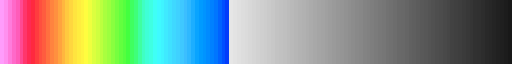

In [24]:
c1 = cmaps.GMT_wysiwygcont.reversed()
c2 = cmaps.gray.reversed()
cmap_tb = concat_cmaps([c1, c2], [0.45, 0.55], discrete=135, trim_left=0.1, trim_right=0.1)
cmap_tb

Text(0.5, 1.0, 'HEALPix Precipitation (order 9)')

Text(0.5, 1.0, 'HEALPix Precipitation (order 9)')

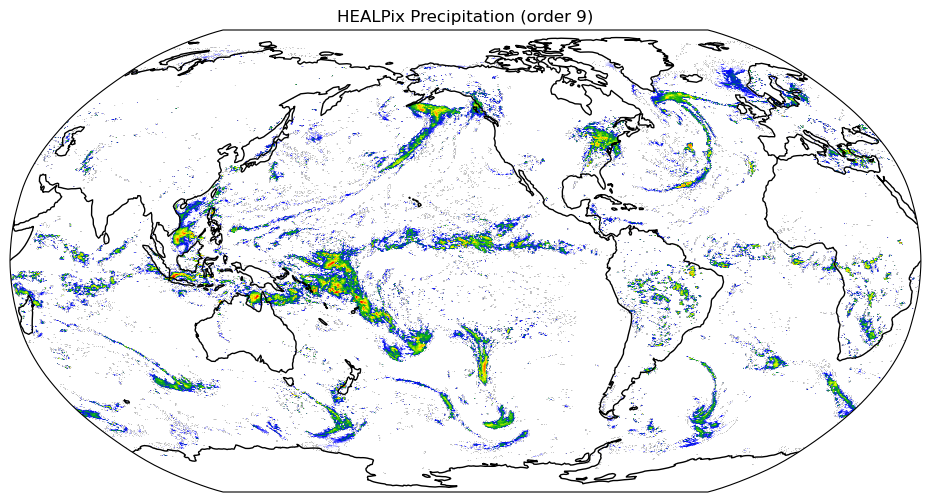

In [28]:
fig = plt.figure(figsize=(15, 6))

ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-137))
ax2.set_global()
ax2.coastlines()

egh.healpix_show(ds_remap.precipitation.isel(time=0), ax=ax2, norm=mpl.colors.LogNorm(vmin=10e-2, vmax=30), cmap=cmaps.WhBlGrYeRe)
ax2.set_title(f'HEALPix Precipitation (order {order})')

In [29]:
# # Plot original data
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# fig = plt.figure(figsize=(15, 6))

# # Original grid (left subplot)
# ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
# ds.Tb.isel(time=0).plot(ax=ax1, cmap=cmap_tb, vmin=180, vmax=315)
# ax1.set_title('Original Lat/Lon Grid')
# ax1.set_aspect('equal')
# ax1.coastlines()

# # HEALPix grid (right subplot) with proper projection
# ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.Robinson(central_longitude=-137))
# ax2.set_global()
# ax2.coastlines()

# # HEALPix grid using easygems with projection
# egh.healpix_show(ds_remap.Tb.isel(time=0), ax=ax2, cmap=cmap_tb, vmin=180, vmax=315)
# ax2.set_title(f'HEALPix Grid (order {order})')

# plt.tight_layout()
# plt.show()

In [30]:
# Compare precipitation data
fig = plt.figure(figsize=(15, 6))

# Original precipitation (left subplot)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
pcp = ds.precipitation.isel(time=0).transpose('lat', 'lon')
pcp.plot(ax=ax1, norm=mpl.colors.LogNorm(vmin=10e-2, vmax=30), cmap=cmaps.WhBlGrYeRe)
ax1.set_title('Original Precipitation (mm/hr)')
ax1.set_aspect('equal')
ax1.coastlines()

# HEALPix precipitation (right subplot) with proper projection
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.Robinson(central_longitude=-137))
ax2.set_global()
ax2.coastlines()

# HEALPix precipitation using easygems
egh.healpix_show(ds_remap.precipitation.isel(time=0), ax=ax2, norm=mpl.colors.LogNorm(vmin=10e-2, vmax=30), cmap=cmaps.WhBlGrYeRe)
ax2.set_title(f'HEALPix Precipitation (order {order})')

plt.tight_layout()
plt.show()

## Check data conservation

In [ ]:
# Compare statistics to check if remapping preserved the data well
print("Data conservation check:")
print("\nTemperature (Tb):")
print(f"Original - Mean: {ds.Tb.isel(time=0).mean().values:.2f}, Std: {ds.Tb.isel(time=0).std().values:.2f}")
print(f"Remapped - Mean: {ds_remap.Tb.isel(time=0).mean().values:.2f}, Std: {ds_remap.Tb.isel(time=0).std().values:.2f}")

print("\nPrecipitation:")
print(f"Original - Mean: {ds.precipitationCal.isel(time=0).mean().values:.4f}, Std: {ds.precipitationCal.isel(time=0).std().values:.4f}")
print(f"Remapped - Mean: {ds_remap.precipitationCal.isel(time=0).mean().values:.4f}, Std: {ds_remap.precipitationCal.isel(time=0).std().values:.4f}")

Data conservation check:

Temperature (Tb):
Original - Mean: 273.47, Std: 19.19
Remapped - Mean: 274.81, Std: 19.33

Precipitation:
Original - Mean: 0.1336, Std: 0.8787
Remapped - Mean: 0.1390, Std: 0.9117


In [ ]:
print("\nPrecipitation:")
print(f"Original - Mean: {ds.precipitationCal.isel(time=0).mean().values:.4f}, Std: {ds.precipitationCal.isel(time=0).std().values:.4f}")
print(f"Remapped - Mean: {ds_remap.precipitationCal.isel(time=0).mean().values:.4f}, Std: {ds_remap.precipitationCal.isel(time=0).std().values:.4f}")


Precipitation:
Original - Mean: 0.1336, Std: 0.8787
Remapped - Mean: 0.1390, Std: 0.9117


## Working with Multiple Files (Batch Processing)

Example of how to process multiple files using the same weights:

In [ ]:
# Example batch processing (uncomment to use)
# input_files = ["file1.nc", "file2.nc", "file3.nc"]
# 
# for i, input_file in enumerate(input_files):
#     print(f"Processing file {i+1}/{len(input_files)}: {input_file}")
#     
#     # Load dataset
#     ds = xr.open_dataset(input_file, chunks={'time': 1, 'lat': 900, 'lon': 1800})
#     
#     # Remap using existing weights (much faster for subsequent files)
#     ds_remap = remap_latlon_to_healpix(ds, order=9, weights_file=weights_file)
#     
#     # Save remapped file
#     output_file = f"{Path(input_file).stem}_healpix_z9.nc"
#     ds_remap.to_netcdf(output_file, encoding={'Tb': {'zlib': True, 'complevel': 4},
#                                               'precipitationCal': {'zlib': True, 'complevel': 4}})
#     
#     print(f"  Saved: {output_file}")